In [1]:
#%matplotlib notebook
import time, winsound, h5py, os
import numpy as np
import matplotlib.pyplot as plt
from lcls_beamline_toolbox.xraybeamline2d import beam1d as beam, optics1d as optics, beamline1d as beamline

### Beam parameters

In [2]:
# number of sampling points
N = 2048
# photon energy in eV
E0 = 17795

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 630
}

### Propagate central energy only (no time component) to tune lens roc

In [3]:
def define_devices(
    f1, f2, slit_width = 500e-6, alphaAsym = np.deg2rad(27.98), E0=E0, f0 = 290., d23=7.):
    # crystal reflection hkl index
    hkl = [6,6,0]

    # viewing point upstream of monochromator
    im0 = optics.PPM('im0', z=870, FOV=2e-3, N=256)
    crl0 = optics.CRL('crl0', z=920, E0=E0, f=f0, diameter=2e-3)

    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=930, E0=E0,
                              alphaAsym=0, orientation=0, pol='s', delta=0.e-6)

    # second crystal: asymmetric reflection, orientation flipped relative to crystal1
    crystal2 = optics.Crystal('c2', hkl=hkl, length=10e-2, width=20e-3, z=crystal1.z+.2, E0=E0,alphaAsym=alphaAsym, 
                              orientation=2,pol='s', delta=0e-6)
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    im_upstream = optics.PPM('im_upstream', z=crystal2.z + f1 - .1, FOV=2e-3, N=256)

    # CRL with ~1 meter focal length (modeled as single element for now)
    crl1 = optics.CRL('crl1', z=crystal2.z+f1, E0=E0, f=f2, diameter=5e-3)

    # viewing point downstream of first crl
    im1 = optics.PPM('im1', z=crl1.z+.1,N=256,FOV=2e-3)

    # viewing point at focus
    focus = optics.PPM('focus', z=crl1.z+f2, FOV=100e-6, N=256)

    # slit at focus
    slit = optics.Slit('slit', z=crl1.z+f2 + 1e-3, x_width=slit_width, y_width=2e-3)

    # second CRL with ~1 meter focal length, for collimation
    crl2 = optics.CRL('crl2', z=crl1.z+2*f2, E0=E0, f=f2, diameter=5e-3)

    # third crystal, symmetric reflection, same orientation as crystal2
    crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=crl2.z+d23, E0=E0,alphaAsym=0, orientation=2,
                             asym_type='emergence',pol='s')

    # fourth crystal, asymmetric reflection, same orientation as crystal1
    crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=crl2.z+d23 + (f1-d23)*np.cos(crystal1.beta0*2), E0=E0,alphaAsym=-alphaAsym, 
                              asym_type='emergence', orientation=0,pol='s')

    # viewing point just downstream of monochromator
    im2 = optics.PPM('im2', z=crystal4.z+.1, FOV=2e-3, N=256)

    # list of devices to propagate through
    devices = [crl0,im0,crystal1,crystal2,im_upstream, im1, crl1, focus, slit, crl2, crystal3, crystal4, im2]

    return devices

### Propagate central energy only (no time component) to tune lens roc

In [4]:
# initialize optical elements
f1 = 9.775183946488294
f2 = 10.

devices = define_devices(f1, f2)

# initialize beamline
mono_beamline = beamline.Beamline(devices)

for oe in devices:
    if oe.name == 'c1':
        print('crystal 1 incidence angle: {:.2f} degrees'.format(oe.alpha*180/np.pi))
        print('crystal 1 exit angle: {:.2f} degrees\n\n\n'.format(oe.beta0*180/np.pi))
        
# propagate
b1 = beam.Beam(beam_params=beam_params)
b2 = mono_beamline.propagate_beamline(b1)

b 1.00
b 10.01
crystal 2 incidence angle: 60.96 degrees
crystal 2 exit angle: 5.01 degrees
b 1.00
b 0.10
after c1: 1.1511
after c2: -0.0002
after c3: -1.1513
after c4: -0.0002
crystal 1 incidence angle: 32.98 degrees
crystal 1 exit angle: 32.98 degrees



FWHM in x: 38.3817560828058 microns
FWHM in y: 38.3817560828058 microns
FWHM Divergence (x): 1.1 μrad
FWHM Divergence (y): 1.1 μrad
23.8534886531404
23.8534886531404
x is focused
y is focused
FWHM in x: 274.41237703727336 microns
FWHM in y: 274.41237703727336 microns
FWHM Divergence (x): 1.1 μrad
FWHM Divergence (y): 1.1 μrad
23.8534886531404
23.8534886531404
x is focused
y is focused
im0
zx: 240.000000
zy: 240.000000
azimuth 0.00 mrad
drift1
global_x 0.00
global_y 0.00
x intersect: 0.0000e+00
component x: 0.0000e+00
y intersect: 0.0000e+00
component y: 0.0000e+00
delta z: 0.00
zRx: 342624082.92 microns
zRy: 342624082.92 microns
remaining distance: 50000000.00 microns
goal for zx: 290000000.00 microns
current zx: 240000000.00 microns


zx: -22474229088.211308
zy: 340.142536
azimuth -0.22 mrad


C:\Users\nanw0\Anaconda3\envs\lcls\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


### Propagate energy components and plot beam profiles


In [9]:
%%capture capt
tstart = time.time()
# propagate
beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, tau=400, time_window=10000)
pulse.propagate(beamline=mono_beamline, screen_names=['im1','focus','im2'])
tfin = time.time()

total 5.9s, per slice 105.35ms


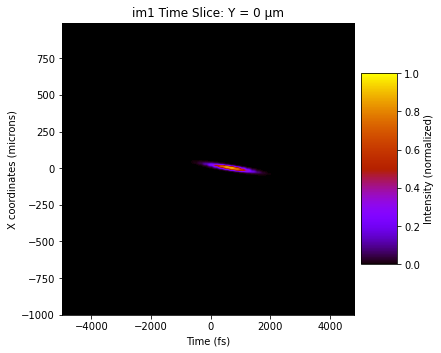

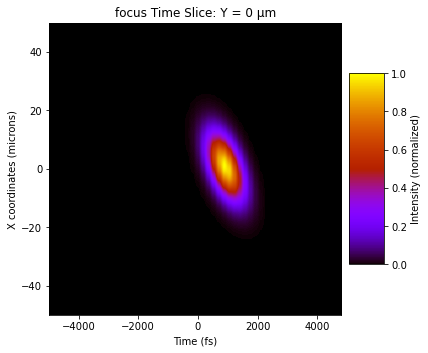

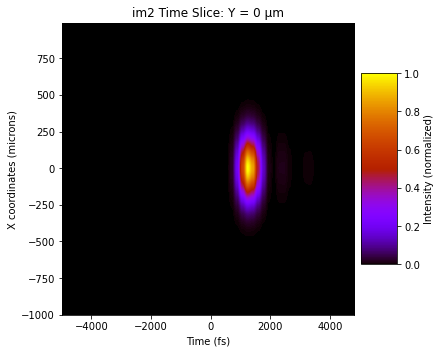

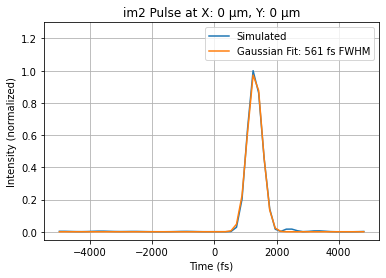

In [10]:
''' time slice '''
print('total {}s, per slice {}ms'.format(round(tfin-tstart,2), round(1000*(tfin-tstart)/pulse.N,2)))

shift = 0
pulse.imshow_time_slice('im1',shift=shift)
pulse.imshow_time_slice('focus', shift = shift)
pulse.imshow_time_slice('im2', shift = shift)
pulse.plot_pulse('im2', shift = shift)

#for i in range(2):
#    winsound.Beep(1000,1000)

### Optimization

In [7]:
%%capture capt
tstart = time.time()
NN = 500
f1 = np.linspace(9.72, 9.82, NN)

duration = np.zeros(NN)

for i, f in enumerate(f1):
    devices = define_devices(f, 10)
    # initialize beamline
    mono_beamline = beamline.Beamline(devices)
    # reset central photon energy
    beam_params['photonEnergy'] = E0

    # initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
    pulse = beam.Pulse(beam_params=beam_params, tau=400, time_window=10000)

    print('Number of spectral components: {:d}'.format(pulse.N))
    pulse.propagate(beamline=mono_beamline, screen_names=['im2'])
    centroid, duration[i] = pulse.pulse_duration('im2')
tfin = time.time()


In [8]:
fig_path = "C:/Users/nanw0/GoogleDrive/SLAC/SLAC-Diling/9. 20 Summer/Hasan Mono Analysis/Matt's_Plots/"
hkl = devices[2].hkl
hkl = int(hkl[0]*100+hkl[1]*10+hkl[2])
fname = 'pulse_duration_{}_{}keV'.format(
    hkl, round(beam_params['photonEnergy']/1000.,4))

with h5py.File(fig_path+fname+'.h5','w') as f:
    f.create_dataset('f1', data=f1)
    f.create_dataset('duration', data=duration)

9.770901803607215


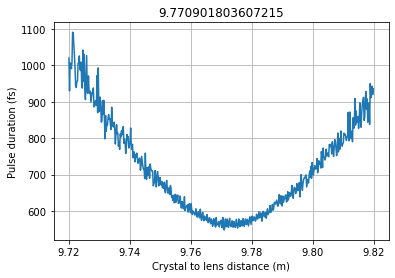

In [9]:
# plot range
f1_min = f1.min()
f1_max = f1.max()
ii = np.argwhere(f1>=f1_min).min()
ifin = np.argwhere(f1<=f1_max).max()

plt.figure()
plt.plot(f1[ii:ifin], np.abs(duration[ii:ifin]))
plt.xlabel('Crystal to lens distance (m)')
plt.ylabel('Pulse duration (fs)')
# plt.ylim(0,200)
plt.grid()
f1_opt = f1[ii:ifin][np.argmin(duration[ii:ifin])]
plt.title(f1_opt)
plt.savefig(fig_path+fname+'_{}-{}m.png'.format(round(f1_min,2), round(f1_max,2)))

print(f1_opt)

In [10]:
for i in range(2):
    winsound.Beep(300,1000)